In [24]:
from pathlib import Path
import requests
from PIL import Image
from io import BytesIO

import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sn
import matplotlib.pyplot as plt

# Predicting droughts and weather from weather data
The International Crops Research Institute for the Semi-Arid Tropics (ICRISAT) is an international organization which conducts agricultural research for rural development, headquartered in Hyderabad, Telangana, India.

Founded in 1972 by a consortium of organisations convened by the Ford and the Rockefeller foundations, ICRISAT’s charter was signed by The Food and Agriculture Organization of the United Nations (FAO) and The United Nations Development Programme (UNDP).

ICRISAT has been collecting detailed daily weather data in Hyderabad since 1978, and published a 40-year dataset of daily weather readings. I will use this dataset as the first dataset for my analysis.

## Datasets
1. ICRISAT daily weather dataset for 1978-2018, collected in Hyderabad.
1. Integrated drought index data monthly dataset for 1951-2016, of Hyderabad.
1. Qualitative indication of drought years for 1901-2009, of Telangana state, India.

## Questions
1. Which, if any, of the weather features collected by ICRISAT appear to be correlated with each other?
1. Which years had the highest average and median rainfall, humidity and radiation? Which periods had the lowest?
1. Analyse the relationship between FAO56 ET (proxying crop yield) and other weather features.
1. Can any of the weather features collected indicate or predict drought?


Firstly, I will write a function to load data from the Vocareum folder into a pandas DataFrame.

The `load_data()` function also prints `DataFrame.info()`, `DataFrame.describe()` and `DataFrame.head()` to provide a sense of what the dataset contains.

In [2]:
def load_data(file: Path, **kwargs):
    '''
    Wrapper function to
        1. Loads data into a DataFrame, and
        2. Prints df.info() and df.describe().
    :param file: Path of file location
    :param kwargs: kwargs to pass to pd.read_csv() or pd.read_excel()
    :return: pd.DataFrame
    '''
    # reads data into df then and prints description and info
    if 'xls' in file.suffix:
        df = pd.read_excel(file, **kwargs)
    elif 'csv' in file.suffix:
        df = pd.read_csv(file, **kwargs)
    else:
        print(file.suffix)
        raise NotImplementedError

    print(f"===== df.info output =====")
    df.info()
    print(f"\n\n===== df.describe output =====\n", df.describe())
    print("\n\n===== df.head output =====\n", df.head())
    return df

## Dataset: ICRISAT weather observations

In [3]:
cwd = Path.cwd()  # reads current working directory to simplify working with files
weather_df = load_data(cwd / "data" / "ICRISAT Weather 1978 to 2018.xlsx")

===== df.info output =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14853 entries, 0 to 14852
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Station    14853 non-null  object        
 1   Date       14853 non-null  datetime64[ns]
 2   MaxT       14853 non-null  float64       
 3   MinT       14853 non-null  float64       
 4   RH1        14853 non-null  int64         
 5   RH2        14853 non-null  float64       
 6   Wind       14853 non-null  float64       
 7   Rain       14853 non-null  float64       
 8   SSH        14853 non-null  float64       
 9   Evap       14853 non-null  float64       
 10  Radiation  14852 non-null  float64       
 11  FAO56_ET   14853 non-null  float64       
 12  Lat        14853 non-null  float64       
 13  Lon        14853 non-null  float64       
 14  Cum_Rain   14853 non-null  float64       
dtypes: datetime64[ns](1), float64(12), int64(1), object(1)
memor

### Dataset: ICRISAT - fields
The ICRISAT data is at the day level and includes the following fields:

| #   | Column Name        | Description                                   |
|-----|:-------------------|:----------------------------------------------|
| 0   | Station            | Single value "ICRISAT"                        |
| 1   | Date               | Date of collection of weather data            |
| 2   | MaxT               | Maximum temperature (°C)                      |
| 3   | MinT               | Minimum temperature (°C)                      |
| 4   | RH1                | Relative humidity in the morning (%)          |
| 5   | RH2                | Relative humidity in the afternoon (%)        |
| 6   | Wind               | Wind (km/h)                                   |
| 7   | Rain               | Rain (mm)                                     |
| 8   | SSH                | Bright sunshine (hour)                        |
| 9   | Evap               | Evaporation (mm)                              |
| 10  | Radiation          | Radiation (mm/hour)                           |
| 11  | FAO56<sub>ET</sub> | FAO 56 reference crop evapotranspiration (mm) |
| 12  | Lat                | Latitude of collection point                  |
| 13  | Lon                | Longitude of collection point                 |
| 14  | Cum<sub>Rain</sub> | Cumulative monthly rainfall (mm)              |


### Dataset: ICRISAT - Preview of data

In [20]:
weather_df.sample(10, random_state=42).sort_index()

,Station,Date,MaxT,MinT,RH1,RH2,Wind,Rain,SSH,Evap,Radiation,FAO56_ET,Lat,Lon,Cum_Rain
169,ICRISAT,1978-06-19,25.9,22.3,90,93.0,24.2,2.6,0.0,2.3,5.9,1.6,17.508409,78.2723,258.2
2614,ICRISAT,1985-02-27,34.5,15.0,58,17.0,3.7,0.0,10.8,6.8,20.7,4.6,17.508409,78.2723,1.8
2974,ICRISAT,1986-02-22,31.0,18.5,96,40.0,9.5,0.0,10.4,6.6,21.1,5.1,17.508409,78.2723,96.6
3838,ICRISAT,1988-07-05,33.8,22.5,92,42.0,15.5,1.8,9.1,7.8,20.4,6.4,17.508409,78.2723,243.0
5902,ICRISAT,1994-02-28,33.0,16.5,69,23.0,4.4,0.0,10.8,7.2,22.7,4.9,17.508409,78.2723,7.4
6860,ICRISAT,1996-10-13,31.0,18.0,82,34.0,4.2,0.0,10.4,7.6,22.3,4.6,17.508409,78.2723,1016.2
9129,ICRISAT,2002-12-30,30.2,13.5,86,27.0,5.0,0.0,9.6,5.4,15.6,3.6,17.508409,78.2723,627.5
11764,ICRISAT,2010-03-18,36.3,19.5,72,23.0,7.3,0.0,8.3,8.6,18.4,5.8,17.508409,78.2723,42.0
12243,ICRISAT,2011-07-10,33.2,22.8,81,42.0,15.2,0.0,10.4,9.4,19.8,6.5,17.508409,78.2723,101.7
13847,ICRISAT,2015-11-30,31.2,21.8,82,36.0,7.9,0.0,9.6,4.2,16.6,4.4,17.508409,78.2723,376.3


### Dataset: ICRISAT - location of station
The coordinates of the ICRISAT research station are at:

In [11]:
coordinates = (weather_df.loc[0, 'Lat'], weather_df.loc[0, 'Lon'])
coordinates

(17.5084095, 78.2723004)

Let's visualise this location on a map:

In [12]:
px.scatter_mapbox(weather_df, lat='Lat', lon='Lon', mapbox_style='open-street-map')

## Dataset: Integrated Drought Index (IDI)

Drought is a multifaceted weather phenomenon and can be characterised as meteorological, agricultural, hydrological, and groundwater droughts.

A drought index can be used to characterize drought, typically using gridded maps at regional and national levels. These indices help to characterise the different types of drought and quantify severity levels as well as onset and termination of drought.

The Integrated Drought Index (IDI) dataset is a drought index developed by Shah & Mishra (2020) that integrates the effects of these types of droughts into a single indicator.

Shah & Mishra (2020) has published monthly IDI from their study in 0.25° grids. The closest grid to the ICRISAT station was selected and read below into `drought_df`.

In [21]:
drought_df = load_data(cwd / "data" / "data_17.625_78.375.csv", header=None,
                       delim_whitespace=True, names=['year', 'month', 'idi'])

===== df.info output =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 792 entries, 0 to 791
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    792 non-null    int64  
 1   month   792 non-null    int64  
 2   idi     792 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 18.7 KB


===== df.describe output =====
              year       month           idi
count   792.00000  792.000000  7.920000e+02
mean   1983.50000    6.500000 -1.055556e-07
std      19.06241    3.454234  9.999984e-01
min    1951.00000    1.000000 -2.983100e+00
25%    1967.00000    3.750000 -7.323450e-01
50%    1983.50000    6.500000 -2.742200e-03
75%    2000.00000    9.250000  7.447425e-01
max    2016.00000   12.000000  2.365900e+00


===== df.head output =====
    year  month      idi
0  1951      1 -0.74581
1  1951      2 -0.75763
2  1951      3 -0.60874
3  1951      4 -0.41773
4  1951      5 -0.28236


## Dataset: IDI - fields

The IDI data is at the month level and includes the following fields:

| #   | Column Name | Description                            |
|-----|:------------|:---------------------------------------|
| 0   | Year        | Year                                   |
| 1   | Month       | Month                                  |
| 2   | IDI         | Integrated Drought Index - index value |

## Dataset: IDI - Preview of data

In [23]:
drought_df.sample(10, random_state=42).sort_index()

,year,month,idi
63,1956,4,-0.092112
120,1961,1,-1.005200
137,1962,6,1.142600
281,1974,6,0.749100
515,1993,12,-1.841800
528,1995,1,0.804740
587,1999,12,-1.410700
598,2000,11,-0.088064
606,2001,7,0.383600
694,2008,11,0.607720


# Question 1
>Which, if any, of the weather features collected by ICRISAT are related to each other?

To answer this, I will show a correlation matrix of the ICRISAT dataset.

This can be done directly in a pandas dataframe with `DataFrame.corr()`. To increase visual understanding, I will plot it with a `seaborn` heatmap.

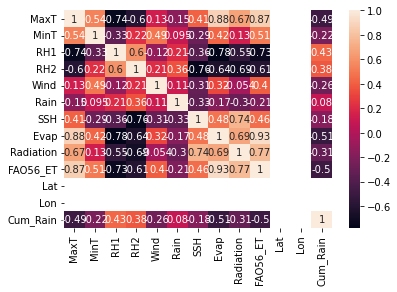

In [49]:
sn.heatmap(weather_df.corr(), annot=True)
plt.show()

I will also query the correlation matrix directly to obtain descriptive statistics, and the top five correlated pairs of variables.

In [58]:
corr_matrix = (weather_df
               .corr()
               .stack()
               .reset_index()
               .rename(columns={'level_0': 'var1', 'level_1': 'var2', 0: 'value'})
               .query("var1 != var2 and var1 < var2")
               )

corr_matrix.describe()

,value
count,55.000000
mean,0.024827
std,0.493801
min,-0.777753
25%,-0.330689
50%,0.079642
75%,0.427742
max,0.928340


In [59]:
(corr_matrix
 .sort_values(by='value', ascending=False)
 .head(5)
 .reset_index(drop=True)
 )

,var1,var2,value
0,Evap,FAO56_ET,0.928340
1,Evap,MaxT,0.876416
2,FAO56_ET,MaxT,0.867453
3,FAO56_ET,Radiation,0.773055
4,Radiation,SSH,0.744162


## Question 1 - conclusion

Most variables of the ICRISAT dataset are not highly correlated with each other.

The top 5 pairs of variables that exhibit correlation are:
1. Evaporation (mm) and FAO 56 reference crop evapotranspiration (mm)
2. Evaporation (mm) and Maximum temperature (°C)
3. FAO 56 reference crop evapotranspiration (mm) and Maximum temperature (°C)
4. FAO 56 reference crop evapotranspiration (mm) and Radiation (mm/hour)
5. Radiation (mm/hour) and Bright sunshine (hour)

In [7]:
drought_df_daily = (drought_df
                    .assign(change_sign=lambda x: np.sign(x.idi).diff().ne(0),
                            is_pos=lambda x: x.idi.gt(0),
                            ds=lambda x: x.idi.gt(0).astype(int).replace(0, -1),
                            days=lambda x: abs(x.groupby((x.ds != x.ds.shift()).cumsum()).cumsum().loc[:, 'ds'])
                            )
                    .drop(columns=['ds', 'change_sign'], axis=1)
                    )